In [1]:
%matplotlib inline

In [2]:
#@title
import jax
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax==0.6.4
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial
from matplotlib import pyplot as plt

# Variational Auto-Encoder (VAE)

Remind that VAE minimizes the following variational bound
$$\text{KL}(p_{\text{data}}(x),p(x|\theta)) \leq \text{KL}(p_{\text{data}}(x)q(z|x;\eta),p(x|z;\theta)p(z|\theta))$$
i.e. 
$$\theta^*,\eta^* = \argmin_{\theta,\eta} \text{KL}(p_{\text{data}}(x)q(z|x;\eta),p(x|z;\theta)p(z|\theta)).$$
Eliminating the terms that don't depend on $\theta,\eta$ and rearranging them, we get
$$\text{Loss}(\eta,\theta) = -\mathbb{E}_{p_{\text{data}}(x)}\mathbb{E}_{q(z|x;\eta)} \log p(x|z;\theta) + \mathbb{E}_{p_{\text{data}}(x)}\text{KL}(q(z|x;\eta), p(z|\theta)).$$
In particular, here we consider the following parameterization.
The approximate posterior is parameterised as a normal distribution
$$q(z|x;\eta) = \mathcal{N}(z|\mu(x;\eta),\sigma(x;\eta)^2),$$
which parameters $\mu(x;\eta),\sigma(x;\eta)$ are defined by a neural network called "encoder".
The join likelihood is defined by another normal distribution
$$p(x|z;\theta) = \mathcal{N}(x|\mu(z;\theta),\sigma(z;\theta)^2),$$
where $\mu(z;\theta),\sigma(z;\theta)$ is defined by the "decoder", and the marginal distribution of latent variables is the standard normal gaussian, i.e.
$$p(z|\theta) = \mathcal{N}(z|0,1).$$

## Generate the data

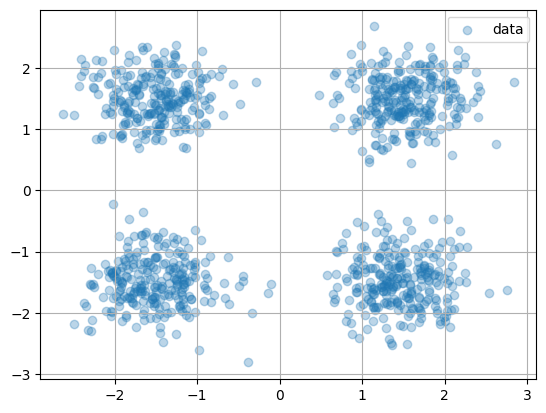

In [3]:
from typing import NamedTuple, Any

def sample_data(key, bs):
    keys = random.split(key, 3)
    label = random.randint(keys[0], minval=0, maxval=2, shape=(bs, 2))
    x_1 = 3*(label.astype(jnp.float32)-0.5)
    x_1 += 4e-1*random.normal(keys[1], shape=(bs,2))
    return x_1, label
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
bs = 512

key, ikey = random.split(key)
data, labels = sample_data(ikey, 1024)
plt.scatter(data[:,0], data[:,1], alpha=0.3, label='data')
plt.legend()
plt.grid()

## Define the Model

For parameterizing both encoder and decoder, we are going to use an MLP that has two outputs: one to parameterize the mean and another to parameterize the variance.

In [4]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, x):
    h = x
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=2*self.num_out)(h)
    return h[:,:self.num_out], h[:,self.num_out:]

In [5]:
latent_dim = 2
encoder = MLP(num_hid=512, num_out=latent_dim)
decoder = MLP(num_hid=512, num_out=data.shape[1])
print(encoder, decoder)
key, *init_key = random.split(key, 3)
state_enc = train_state.TrainState.create(apply_fn=encoder.apply,
                                          params=encoder.init(init_key[0], data),
                                          tx=optax.adam(learning_rate=2e-4))
state_dec = train_state.TrainState.create(apply_fn=decoder.apply,
                                          params=decoder.init(init_key[1], jnp.ones((data.shape[0], latent_dim))),
                                          tx=optax.adam(learning_rate=2e-4))

MLP(
    # attributes
    num_hid = 512
    num_out = 2
) MLP(
    # attributes
    num_hid = 512
    num_out = 2
)


## Loss Function (5 points)
In general, the loss looks like this
$$\text{Loss}(\eta,\theta) = -\mathbb{E}_{p_{\text{data}}(x)}\mathbb{E}_{q(z|x;\eta)} \log p(x|z;\theta) + \mathbb{E}_{p_{\text{data}}(x)}\text{KL}(q(z|x;\eta), p(z|\theta))$$
- Derive the loss for the encoder, decoder, prior parameterized as Gaussians (as described above). Note that you have to find the best estimation, i.e. reduce the objective to the minimum number of Monte Carlo estimates possible. 
- Implement the objective in the function below.
- Train the model with the derived objective. You can generate new batch at each step using the 'sample_data' function. Does the loss curve look meaningful?

In [6]:
def vae_objective(states, key, params, bs):
    state_enc, state_dec = states
    enc_params, dec_params = params
    
    key, subkey1 = random.split(key)
    x, _ = sample_data(subkey1, bs)
    mu_x, logvar_x = state_enc.apply_fn(enc_params, x)

    key, subkey2 = random.split(key)
    z = mu_x + jnp.exp(0.5 * logvar_x) * random.normal(subkey2, shape=mu_x.shape)
    mu_z, logvar_z = state_dec.apply_fn(dec_params, z)

    reconstruction_loss = 0.5 * jnp.sum(
        logvar_z + (x - mu_z)**2 / jnp.exp(logvar_z), 
        axis=-1
    )
    KL_loss = -0.5 * jnp.sum(
        1 + logvar_x - mu_x**2 - jnp.exp(logvar_x), 
        axis=-1
    )
    loss = KL_loss + reconstruction_loss
    print(loss.shape, 'final.shape', flush=True)
    return loss.mean()

@partial(jax.jit, static_argnums=2)
def train_step(state_enc, state_dec, bs, key):
    grad_fn = jax.value_and_grad(vae_objective, argnums=2)
    loss, grads = grad_fn((state_enc, state_dec), key, (state_enc.params, state_dec.params), bs)
    state_enc = state_enc.apply_gradients(grads=grads[0])
    state_dec = state_dec.apply_gradients(grads=grads[1])
    return state_enc, state_dec, loss

key, loc_key = random.split(key)
state_enc, state_dec, loss = train_step(state_enc, state_dec, bs, loc_key)

(512,) final.shape


## Train Loop

In [7]:
num_iterations = 10_000

loss_plot = np.zeros(num_iterations)
for iter in trange(num_iterations):
  key, loc_key = random.split(key)
  state_enc, state_dec, loss = train_step(state_enc, state_dec, bs, loc_key)
  loss_plot[iter] = loss

100%|█████████████████████████████████████| 10000/10000 [02:49<00:00, 58.88it/s]


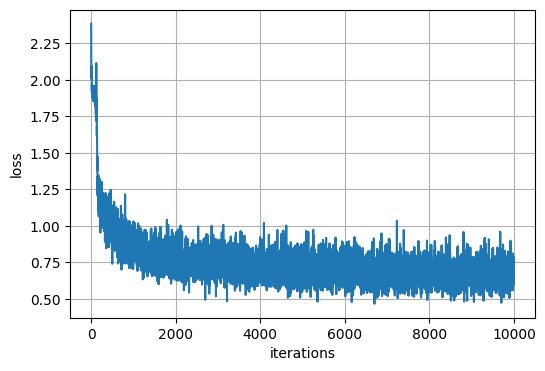

In [8]:
plt.figure(figsize=(6,4))
plt.plot(loss_plot)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.grid()

## Visualization of the Trained Model (5 points for both cells)
For the trained VAE
- Visualize generated samples using $p(x|z;\theta)p(z|\theta)$ and compare them to the samples from the data. Do they match?
- Visualize the latent distribution by sampling from $q(z|x;\eta)p_{\text{data}}(x)$ and compare them to the samples from $p(z|\theta)$. Do they match?

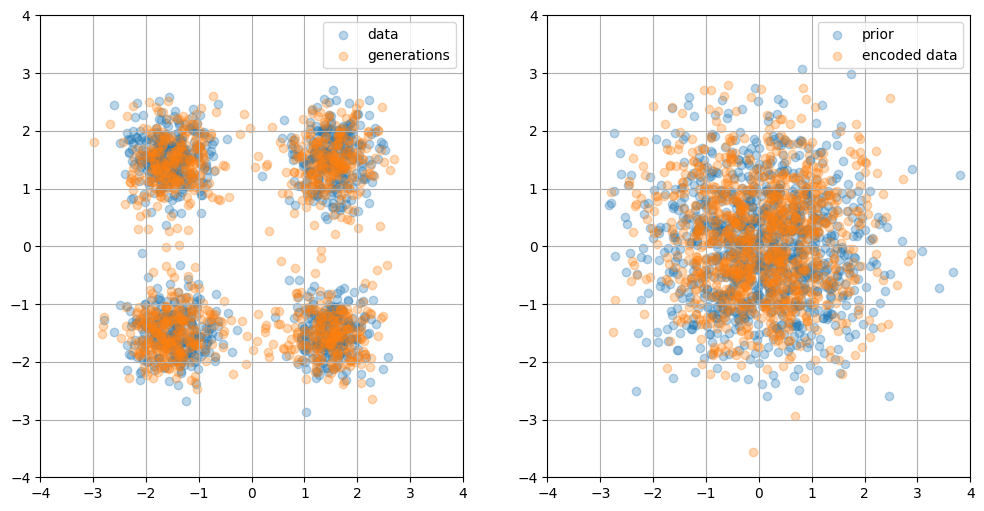

In [9]:
key, subkey1 = random.split(key)
data, labels = sample_data(subkey1, 1024)

key, subkey2 = random.split(key)
z = random.normal(subkey2, shape=(1024, latent_dim))
mu_z, logvar_z = state_dec.apply_fn(state_dec.params, z)

key, subkey3 = random.split(key)
eps_dec = random.normal(subkey3, shape=mu_z.shape)
x_reconstructed = mu_z + jnp.exp(0.5 * logvar_z) * eps_dec

mu_x, logvar_x = state_enc.apply_fn(state_enc.params, data)

key, subkey4 = random.split(key)
eps_enc = random.normal(subkey4, shape=mu_x.shape)

x_encoded = mu_x + jnp.exp(0.5 * logvar_x) * eps_enc

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(data[:,0], data[:,1],
            alpha=0.3, label='data')
plt.scatter(x_reconstructed[:,0], x_reconstructed[:,1],
            alpha=0.3, label='generations')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.legend()
plt.grid()

plt.subplot(122)
plt.scatter(z[:,0], z[:,1],
            alpha=0.3, label='prior')
plt.scatter(x_encoded[:,0], x_encoded[:,1],
            alpha=0.3, label='encoded data')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.legend()
plt.grid()

- Visualize how the latent space is divided between the modes. There is more than one way to visualize this. For instance, use the variable labels produced by 'sample_data', encode the data and color the samples. 

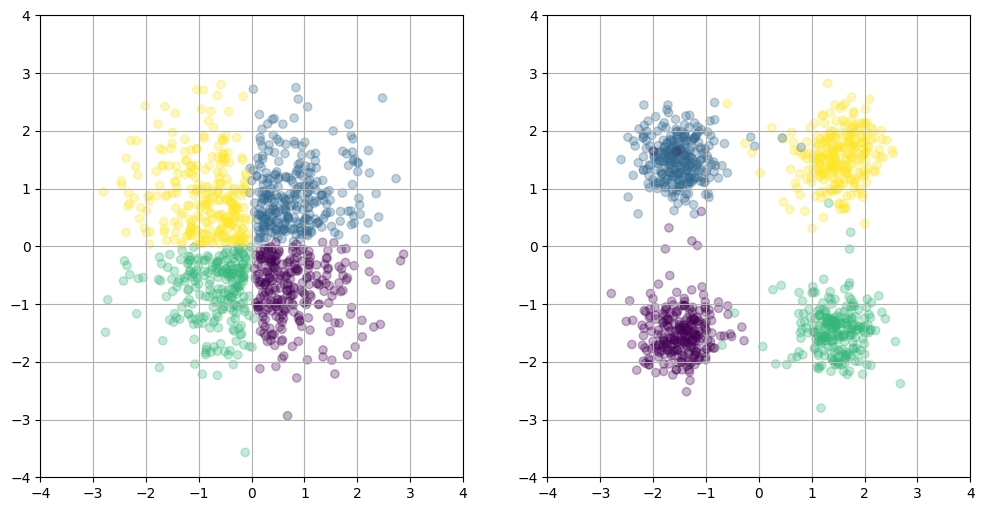

In [10]:
c_labels = [int("".join(map(str, label)), 2) for label in labels]    

mu_z, logvar_z = state_dec.apply_fn(state_dec.params, x_encoded)
key, subkey5 = random.split(key)
eps_vae = random.normal(subkey5, shape=mu_z.shape)
x_vae = mu_z + jnp.exp(0.5 * logvar_z) * eps_vae

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_encoded[:,0], x_encoded[:,1],c=c_labels,
          alpha=0.3)

plt.xlim(-4,4)
plt.ylim(-4,4)
plt.grid()

plt.subplot(122)
plt.scatter(x_vae[:,0], x_vae[:,1], c=c_labels, 
            alpha=0.3)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.grid()

## Evaluation of the trained model (5 points)

Let's evaluate the model by estimating $\mathbb{E}_{p_{\text{data}}(x)}\log p(x|\theta)$. Namely, consider three different estimates:
1. Naive marginal likelihood estimation 
$$\mathbb{E}_{p_{\text{data}}(x)}\log p(x|\theta) = \mathbb{E}_{p_{\text{data}}(x)}\log \int dz\;p(x|z;\theta)p(z|\theta)$$
2. VAE lower bound
$$\mathbb{E}_{p_{\text{data}}(x)}\log p(x|\theta) \geq \mathbb{E}_{p_{\text{data}}(x)} \mathbb{E}_{q(z|x;\eta)}\log \frac{p(x|z;\theta)p(z|\theta)}{q(z|x;\eta)} \approx \mathbb{E}_{p_{\text{data}}(x)} \frac{1}{K}\sum_{k=1}^K\log \frac{p(x|z_k;\theta)p(z_k|\theta)}{q(z_k|x;\eta)}, \;\; z_k \sim q(z|x;\eta)$$
3. IWAE lower bound
$$\mathbb{E}_{p_{\text{data}}(x)}\log p(x|\theta) \geq \mathbb{E}_{p_{\text{data}}(x)}\mathbb{E}_{z_1,\ldots, z_k \sim q(z|x;\eta)}\log \frac{1}{K}\sum_{k=1}^K\frac{p(x|z_k;\theta)p(z_k|\theta)}{q(z_k|x;\eta)}$$

Implement the functions below and compare them by plotting the log-likelihood estimates with the number of samples and estimating the density on the state-space. Which estimate is better?

In [47]:
def marginal_likelihood(key, x, n_samples, state_enc, state_dec):
    total_bound = jnp.empty(shape=x.shape[0])
    log_likelihoods = []
    for _ in range(n_samples):
        key, subkey = random.split(key)
        z = random.normal(subkey, shape=(x.shape[0], latent_dim))
        mu_z, logvar_z = state_dec.apply_fn(state_dec.params, z)
        log_px_given_z = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + logvar_z + (x - mu_z)**2 / jnp.exp(logvar_z), axis=-1)
        log_pz = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + z**2, axis=-1)

        log_likelihoods.append(log_px_given_z + log_pz)

    log_likelihoods = jnp.array(log_likelihoods)
    return jax.scipy.special.logsumexp(log_likelihoods, axis=0) - jnp.log(n_samples)
    

def vae_bound(key, x, n_samples, state_enc, state_dec):
    log_ratios = []
    for _ in range(n_samples):
        key, subkey = random.split(key)
        mu_x, logvar_x = state_enc.apply_fn(state_enc.params, x)
        eps_enc = random.normal(subkey, shape=mu_x.shape)
        z_k = mu_x + jnp.exp(0.5 * logvar_x) * eps_enc 
        mu_z, logvar_z = state_dec.apply_fn(state_dec.params, z_k)
        
        log_px_given_z = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + logvar_z + (x - mu_z)**2 / jnp.exp(logvar_z), axis=-1)
        log_pz = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + z_k**2, axis=-1)
        log_qz_given_x = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + logvar_x + (z_k - mu_x)**2 / jnp.exp(logvar_x), axis=-1)
        log_ratios.append(log_px_given_z + log_pz - log_qz_given_x)
        
    log_ratios = jnp.array(log_ratios)
    return jnp.mean(log_ratios, axis=0)
    

def iwae_bound(key, x, n_samples, state_enc, state_dec):
    log_ratios = []
    for _ in range(n_samples):
        key, subkey = random.split(key)
        mu_x, logvar_x = state_enc.apply_fn(state_enc.params, x)
        eps_enc = random.normal(subkey, shape=mu_x.shape)
        z_k = mu_x + jnp.exp(0.5 * logvar_x) * eps_enc 
        mu_z, logvar_z = state_dec.apply_fn(state_dec.params, z_k)
        
        log_px_given_z = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + logvar_z + (x - mu_z)**2 / jnp.exp(logvar_z), axis=-1)
        log_pz = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + z_k**2, axis=-1)
        log_qz_given_x = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + logvar_x + (z_k - mu_x)**2 / jnp.exp(logvar_x), axis=-1)
        log_ratios.append(log_px_given_z + log_pz - log_qz_given_x)
        
    log_ratios = jnp.array(log_ratios)
    log_mean = jnp.log(jnp.mean(jnp.exp(log_ratios), axis=0))
    return log_mean

In [46]:
key, *ikey = random.split(key, 3)
print('vae bound:', vae_bound(ikey[1], data, 1000, state_enc, state_dec).mean())
print('iwae bound:', iwae_bound(ikey[1], data, 1000, state_enc, state_dec).mean())

n_samples = [1,10,100,1000]
ll_iwae = []
ll_vae = []
for n in n_samples:
  ll_vae.append(vae_bound(ikey[1], data, n, state_enc, state_dec).mean())
  ll_iwae.append(iwae_bound(ikey[1], data, n, state_enc, state_dec).mean())
  
plt.plot(n_samples, ll_vae)
plt.plot(n_samples, ll_iwae)
plt.xscale('log')
plt.xlabel('number of samples')
plt.ylabel('likelihood estimate')
plt.grid()

KeyboardInterrupt: 

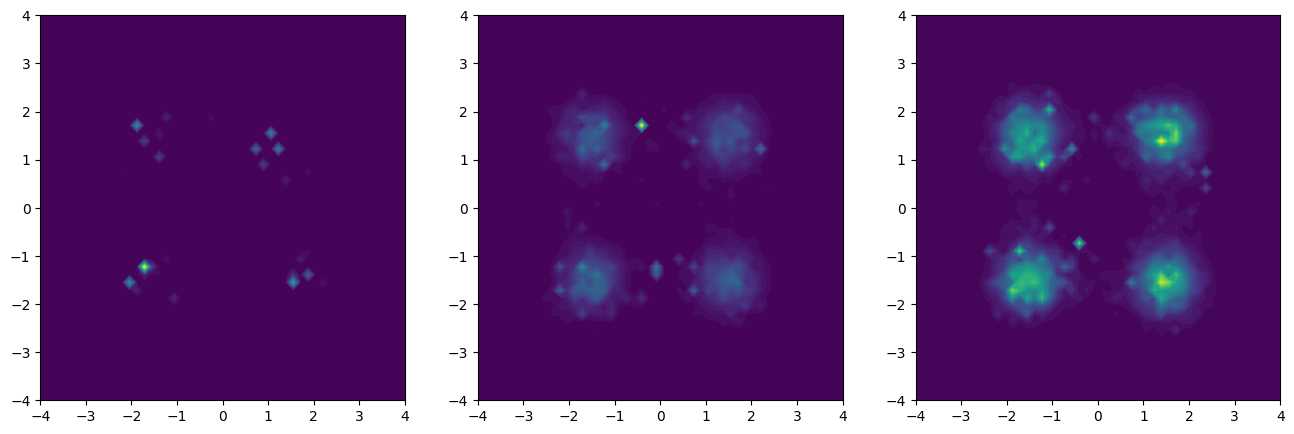

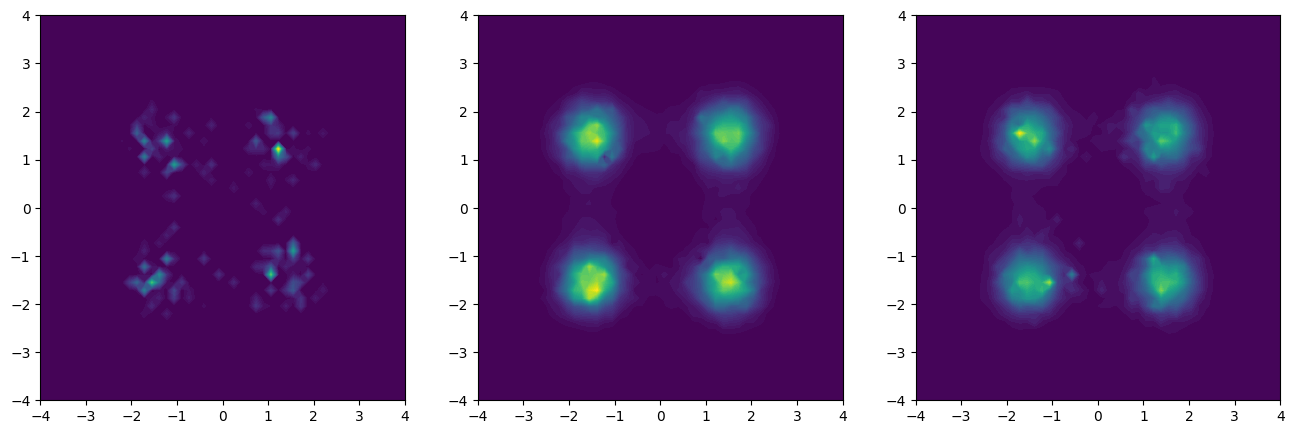

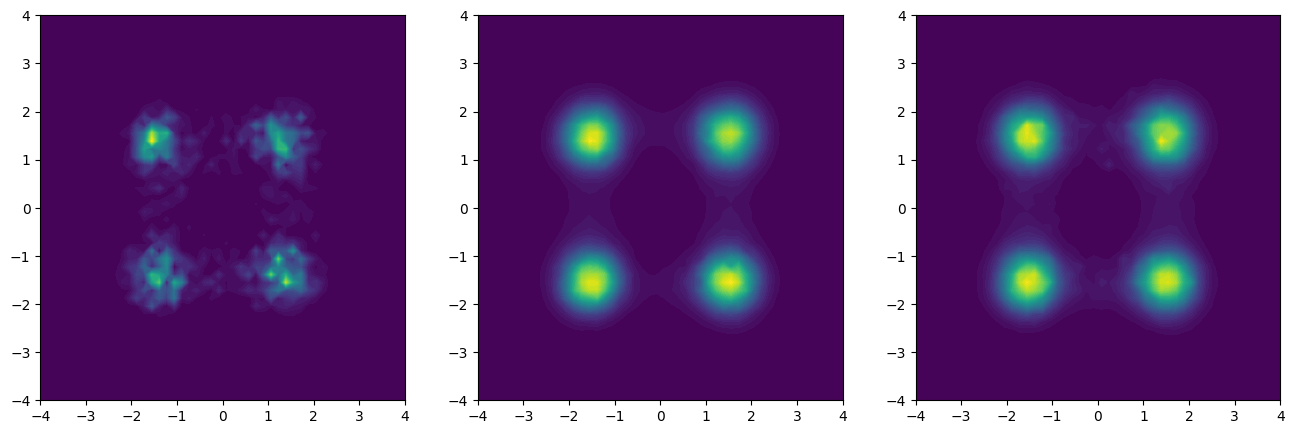

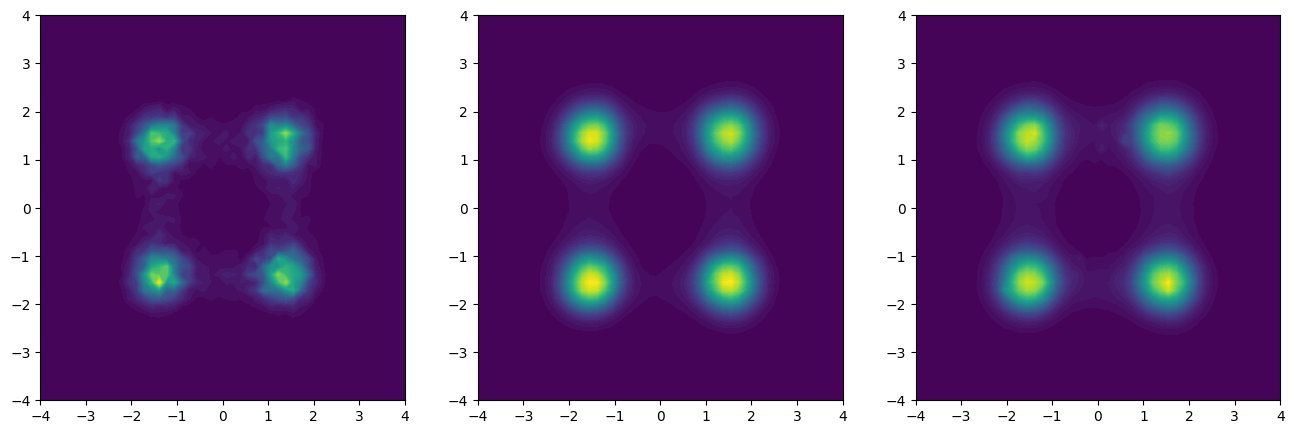

In [13]:
key, *ikey = random.split(key, 4)
x,y = jnp.linspace(-4,4,50), jnp.linspace(-4,4,50)
x,y = jnp.meshgrid(x,y)
grid = jnp.stack([x, y]).transpose((1,2,0)).reshape((-1,2))

for n_samples in [1,10,100,1000]:
  plt.figure(figsize=(16,5))
  
  ll = marginal_likelihood(ikey[0], grid, n_samples, state_enc, state_dec)
  plt.subplot(131)
  plt.contourf(x,y,jnp.exp(ll).reshape(x.shape), levels=50)
  
  ll = vae_bound(ikey[1], grid, n_samples, state_enc, state_dec)
  plt.subplot(132)
  plt.contourf(x,y,jnp.exp(ll).reshape(x.shape), levels=50)

  ll = iwae_bound(ikey[2], grid, n_samples, state_enc, state_dec)
  plt.subplot(133)
  plt.contourf(x,y,jnp.exp(ll).reshape(x.shape), levels=50)
  plt.show()

## Importance Weighted Autoencoder (IWAE)

Why don't we try learning the entire model using IWAE?

In [55]:
latent_dim = 2
encoder = MLP(num_hid=512, num_out=latent_dim)
decoder = MLP(num_hid=512, num_out=data.shape[1])
print(encoder, decoder)
key, *init_key = random.split(key, 3)
state_enc = train_state.TrainState.create(apply_fn=encoder.apply,
                                          params=encoder.init(init_key[0], data),
                                          tx=optax.adam(learning_rate=2e-4))
state_dec = train_state.TrainState.create(apply_fn=decoder.apply,
                                          params=decoder.init(init_key[1], jnp.ones((data.shape[0], latent_dim))),
                                          tx=optax.adam(learning_rate=2e-4))

MLP(
    # attributes
    num_hid = 512
    num_out = 2
) MLP(
    # attributes
    num_hid = 512
    num_out = 2
)


## IWAE objective (5 points)

- Implement the IWAE objective, i.e. 
$$\theta^*,\eta^* = \argmin_{\theta,\eta}-\mathbb{E}_{p_{\text{data}}(x)}\mathbb{E}_{z_1,\ldots, z_k \sim q(z|x;\eta)}\log \frac{1}{K}\sum_{k=1}^K\frac{p(x|z_k;\theta)p(z_k|\theta)}{q(z_k|x;\eta)}$$
- Train the model using the IWAE objective and $K=5$ at every iteration. How does the loss function behave?

In [60]:
def iwae_objective(states, key, params, bs):
    log_ratios = []
    K=5
    state_enc, state_dec = states
    enc_params, dec_params = params
    key, subkey1 = random.split(key)
    x, _ = sample_data(subkey1, bs)
    for _ in range(K):
        key, subkey = random.split(key)
        mu_x, logvar_x = state_enc.apply_fn(enc_params, x)
        eps_enc = random.normal(subkey, shape=mu_x.shape)
        z_k = mu_x + jnp.exp(0.5 * logvar_x) * eps_enc 
        mu_z, logvar_z = state_dec.apply_fn(dec_params, z_k)
        
        log_px_given_z = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + logvar_z + (x - mu_z)**2 / jnp.exp(logvar_z), axis=-1)
        log_pz = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + z_k**2, axis=-1)
        log_qz_given_x = -0.5 * jnp.sum(jnp.log(2*jnp.pi) + logvar_x + (z_k - mu_x)**2 / jnp.exp(logvar_x), axis=-1)
        log_ratios.append(log_px_given_z + log_pz - log_qz_given_x)
        
    log_ratios = jnp.array(log_ratios)
    loss = -jnp.log(jnp.mean(jnp.exp(log_ratios), axis=0))
    print(loss.shape, 'final.shape', flush=True)
    return loss.mean()

@partial(jax.jit, static_argnums=2)
def train_step(state_enc, state_dec, bs, key):
  grad_fn = jax.value_and_grad(iwae_objective, argnums=2)
  loss, grads = grad_fn((state_enc, state_dec), key, (state_enc.params, state_dec.params), bs)
  state_enc = state_enc.apply_gradients(grads=grads[0])
  state_dec = state_dec.apply_gradients(grads=grads[1])
  return state_enc, state_dec, loss

key, loc_key = random.split(key)
state_enc, state_dec, loss = train_step(state_enc, state_dec, bs, loc_key)

(512,) final.shape


In [61]:
num_iterations = 1000

loss_plot = np.zeros(num_iterations)
for iter in trange(num_iterations):
  key, loc_key = random.split(key)
  state_enc, state_dec, loss = train_step(state_enc, state_dec, bs, loc_key)
  loss_plot[iter] = loss

100%|███████████████████████████████████████| 1000/1000 [01:06<00:00, 15.13it/s]


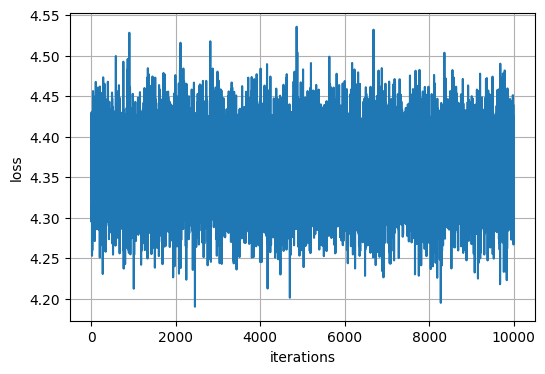

In [51]:
plt.figure(figsize=(6,4))
plt.plot(loss_plot)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.grid()

## Analysis of IWAE (3 points)

- Reproduce the visualizations that you did for VAE for the IWAE.
- Reproduce the plots for the density and log-likelihood estimation.
- How can we compare IWAE and VAE? Which model is better? Why?

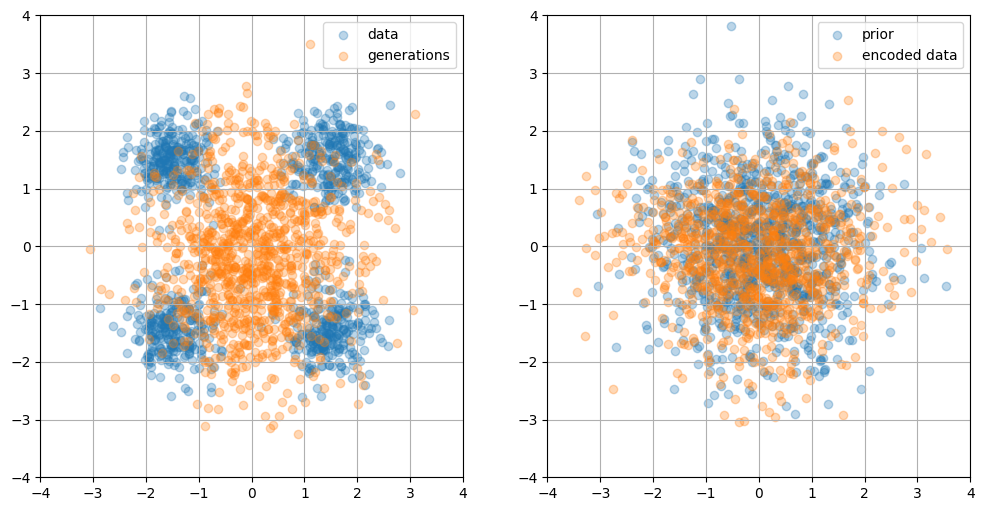

In [235]:
key, subkey1 = random.split(key)
data, labels = sample_data(subkey1, 1024)

key, subkey2 = random.split(key)
z = random.normal(subkey2, shape=(1024, latent_dim))
mu_z, logvar_z = state_dec.apply_fn(state_dec.params, z)

key, subkey3 = random.split(key)
eps_dec = random.normal(subkey3, shape=mu_z.shape)
x_reconstructed = mu_z + jnp.exp(0.5 * logvar_z) * eps_dec

mu_x, logvar_x = state_enc.apply_fn(state_enc.params, data)

key, subkey4 = random.split(key)
eps_enc = random.normal(subkey4, shape=mu_x.shape)

x_encoded = mu_x + jnp.exp(0.5 * logvar_x) * eps_enc

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(data[:,0], data[:,1],
            alpha=0.3, label='data')
plt.scatter(x_reconstructed[:,0], x_reconstructed[:,1],
            alpha=0.3, label='generations')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.legend()
plt.grid()

plt.subplot(122)
plt.scatter(z[:,0], z[:,1],
            alpha=0.3, label='prior')
plt.scatter(x_encoded[:,0], x_encoded[:,1],
            alpha=0.3, label='encoded data')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.legend()
plt.grid()

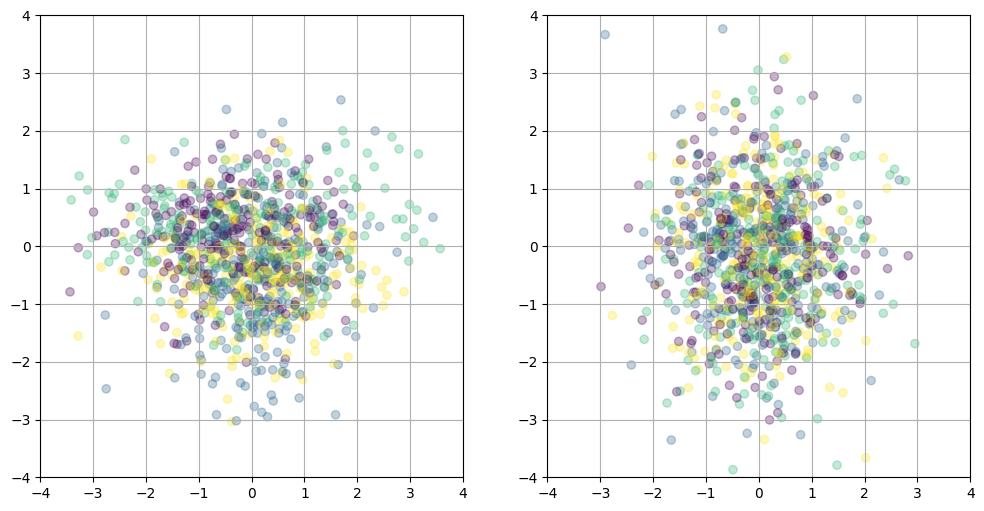

In [236]:
c_labels = [int("".join(map(str, label)), 2) for label in labels]    

mu_z, logvar_z = state_dec.apply_fn(state_dec.params, x_encoded)
key, subkey5 = random.split(key)
eps_vae = random.normal(subkey5, shape=mu_z.shape)
x_vae = mu_z + jnp.exp(0.5 * logvar_z) * eps_vae

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_encoded[:,0], x_encoded[:,1],c=c_labels,
          alpha=0.3)

plt.xlim(-4,4)
plt.ylim(-4,4)
plt.grid()

plt.subplot(122)
plt.scatter(x_vae[:,0], x_vae[:,1], c=c_labels, 
            alpha=0.3)
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.grid()

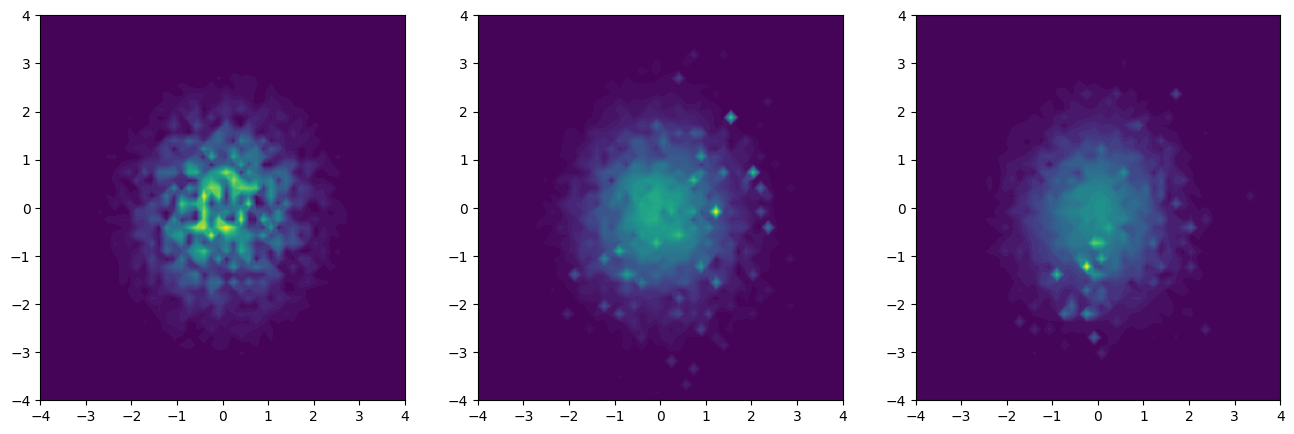

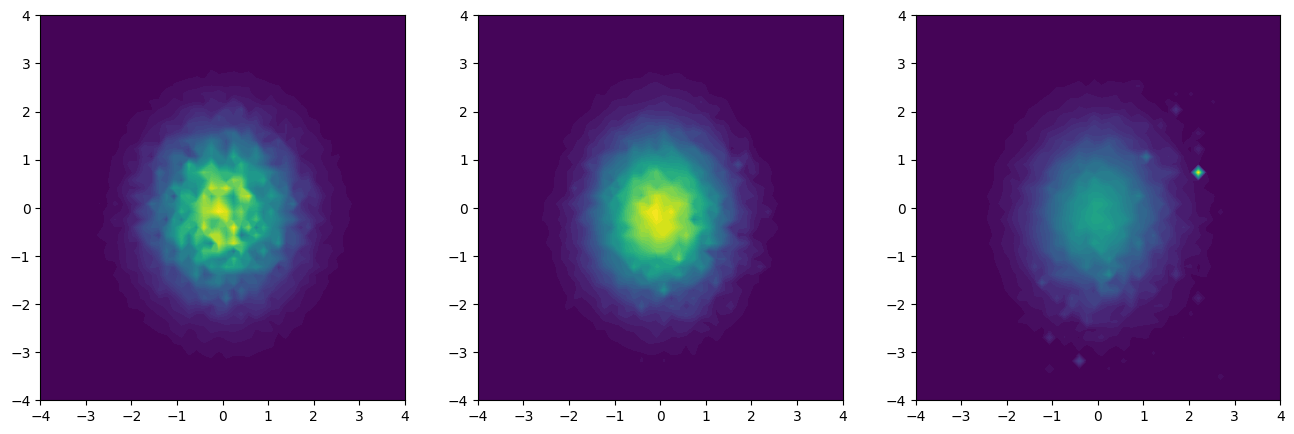

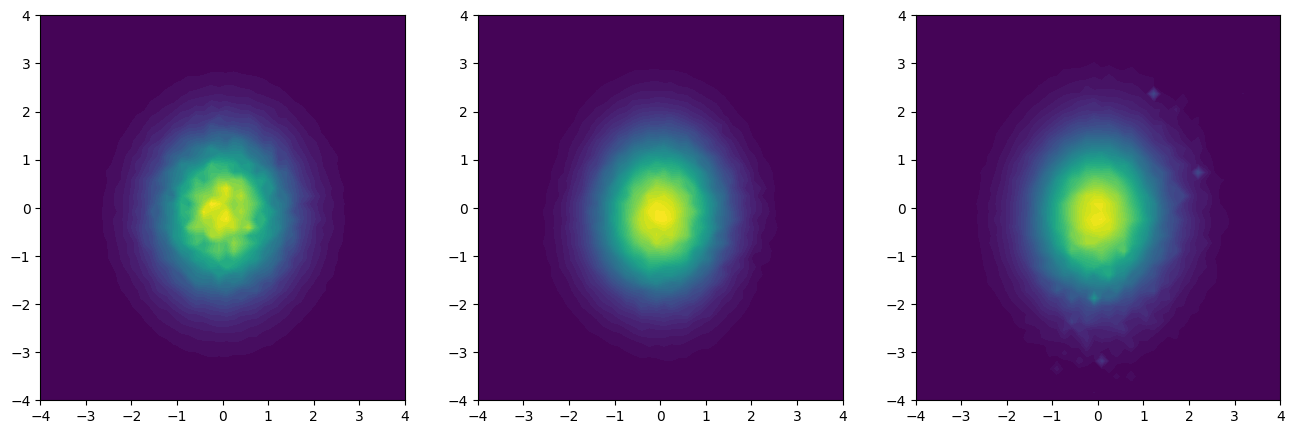

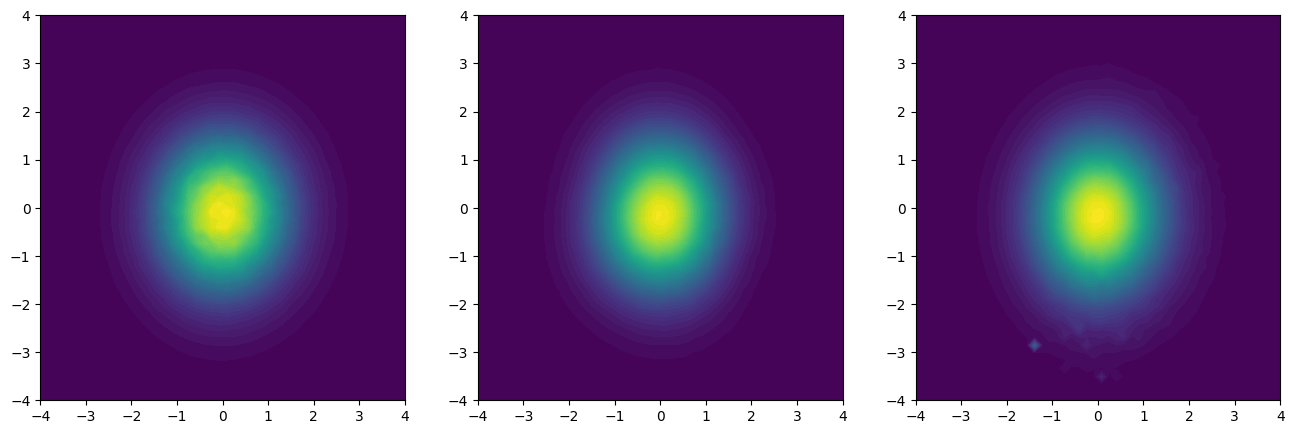

In [237]:
key, *ikey = random.split(key, 4)
x,y = jnp.linspace(-4,4,50), jnp.linspace(-4,4,50)
x,y = jnp.meshgrid(x,y)
grid = jnp.stack([x, y]).transpose((1,2,0)).reshape((-1,2))

for n_samples in [1,10,100,1000]:
  plt.figure(figsize=(16,5))
  
  ll = marginal_likelihood(ikey[0], grid, n_samples, state_enc, state_dec)
  plt.subplot(131)
  plt.contourf(x,y,jnp.exp(ll).reshape(x.shape), levels=50)
  
  ll = vae_bound(ikey[1], grid, n_samples, state_enc, state_dec)
  plt.subplot(132)
  plt.contourf(x,y,jnp.exp(ll).reshape(x.shape), levels=50)

  ll = iwae_bound(ikey[2], grid, n_samples, state_enc, state_dec)
  plt.subplot(133)
  plt.contourf(x,y,jnp.exp(ll).reshape(x.shape), levels=50)
  plt.show()

vae bound: -4.4431815
iwae bound: -4.2100296


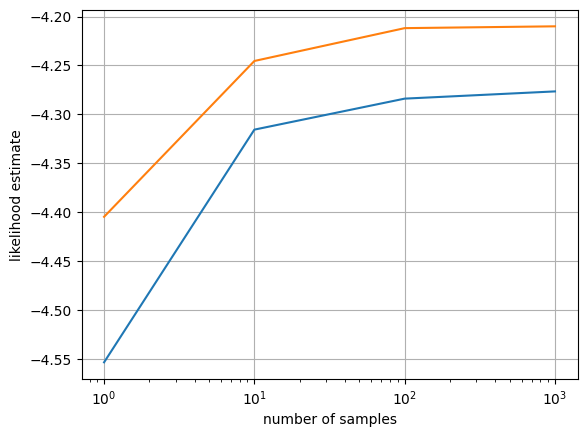

In [238]:
key, *ikey = random.split(key, 3)
print('vae bound:', vae_bound(ikey[1], data, 1000, state_enc, state_dec).mean())
print('iwae bound:', iwae_bound(ikey[1], data, 1000, state_enc, state_dec).mean())

n_samples = [1,10,100,1000]
ll_iwae_trained = []
for n in n_samples:
  ll_iwae_trained.append(iwae_bound(ikey[1], data, n, state_enc, state_dec).mean())
  
plt.plot(n_samples, ll_iwae)
plt.plot(n_samples, ll_iwae_trained)
plt.xscale('log')
plt.xlabel('number of samples')
plt.ylabel('likelihood estimate')
plt.grid()

## Next steps? (Open-ended questions, 2 points)
- What are the next steps for exploring VAE and IWAE?
- Can you come up with a 2d dataset that highlights their differences?
- What happens if we change the dimensionality of the latent space?